In [1]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 3, Finished, Available, Finished)

In [2]:
fact_taxi = spark.table("gold_fact_taxi_daily_staging")
dim_date = spark.table("gold_dim_date_staging")
dim_zone = spark.table("gold_dim_zone_staging")
aq = spark.table("gold_fact_air_quality_daily_staging")
dim_fx = spark.table("gold_dim_fx_staging")
dim_gdp = spark.table("gold_dim_gdp_staging")

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 4, Finished, Available, Finished)

In [3]:
daily_trips = (
    fact_taxi
    .groupBy("date")
    .agg(
        F.sum("trips_count").alias("daily_trips"),
        F.sum("total_revenue_usd").alias("daily_revenue_usd")
    )
    .orderBy("date")
)

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 5, Finished, Available, Finished)

In [4]:
daily_trips_pd = (
    daily_trips
    .toPandas()
    .sort_values("date")
)

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 6, Finished, Available, Finished)

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 7, Finished, Available, Finished)

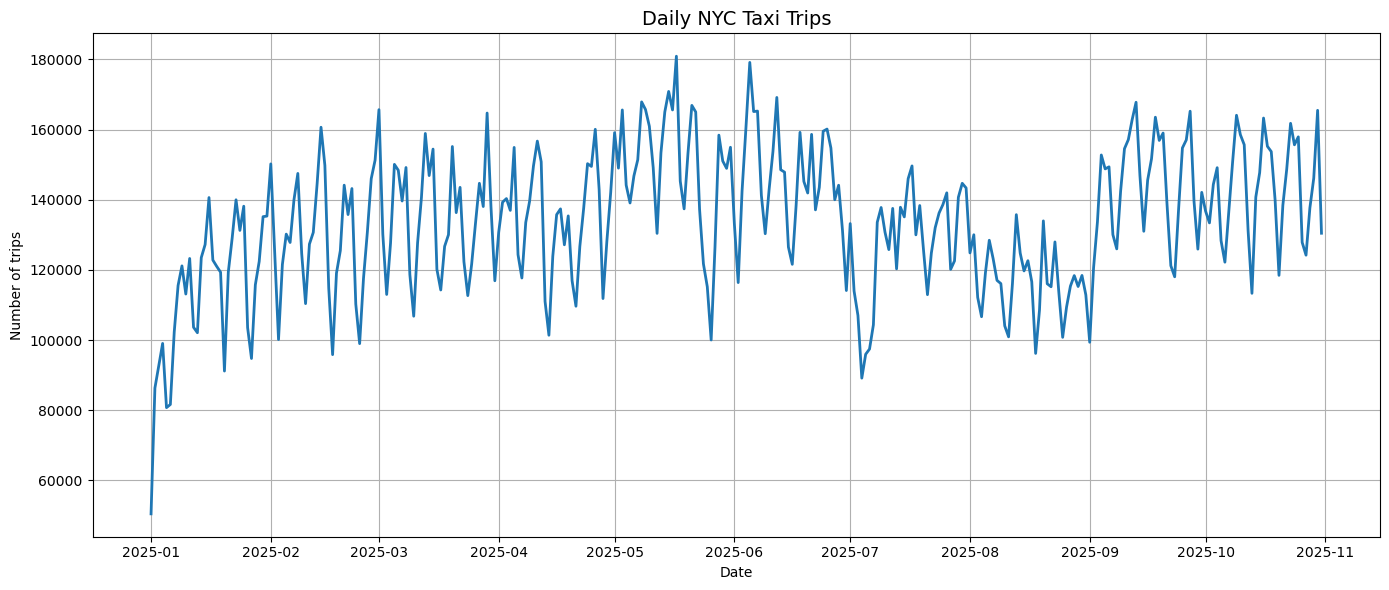

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(daily_trips_pd["date"], daily_trips_pd["daily_trips"], linewidth=2)

plt.title("Daily NYC Taxi Trips", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of trips")
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
avg_fare_daily = (
    spark.table("gold_fact_taxi_daily_staging")
    .groupBy("date")
    .agg(
        (
            F.sum(F.col("avg_fare_usd") * F.col("trips_count")) /
            F.sum("trips_count")
        ).alias("avg_fare_usd")
    )
    .orderBy("date")
)

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 8, Finished, Available, Finished)

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 9, Finished, Available, Finished)

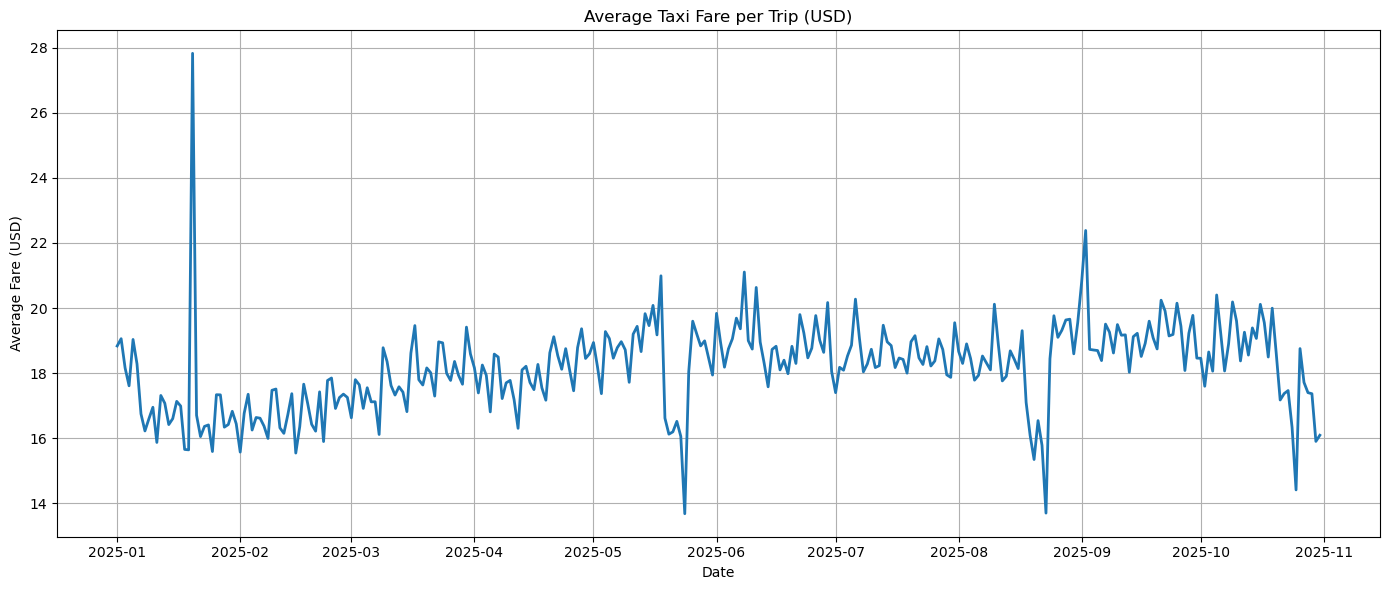

In [7]:
avg_fare_pd = avg_fare_daily.toPandas()

plt.figure(figsize=(14, 6))
plt.plot(
    avg_fare_pd["date"],
    avg_fare_pd["avg_fare_usd"],
    linewidth=2
)

plt.title("Average Taxi Fare per Trip (USD)")
plt.xlabel("Date")
plt.ylabel("Average Fare (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
top_zones = (
    fact_taxi
    .groupBy("pickup_zone_id")
    .agg(F.sum("trips_count").alias("total_trips"))
    .orderBy(F.desc("total_trips"))
    .limit(10)
)

top_zones_named = (
    top_zones
    .join(
        dim_zone,
        top_zones.pickup_zone_id == dim_zone.zone_id,
        "left"
    )
    .select(
        F.concat_ws(
            " - ",
            dim_zone.zone_id,
            dim_zone.borough
        ).alias("zone_name"),
        "total_trips"
    )
)

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 10, Finished, Available, Finished)

In [9]:
top_zones_pd = top_zones_named.toPandas()

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 11, Finished, Available, Finished)

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 12, Finished, Available, Finished)

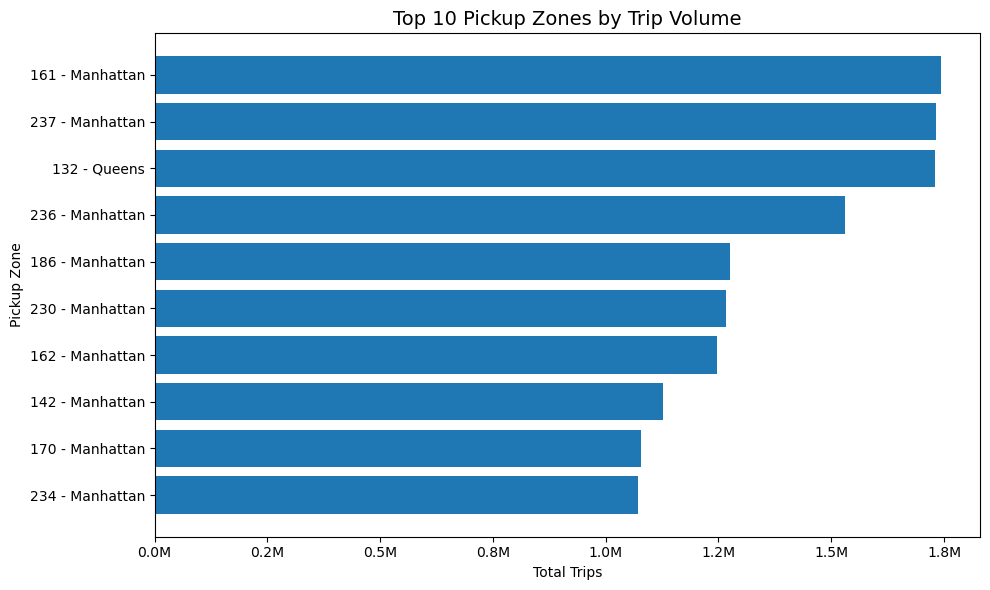

In [10]:
top_zones_pd = top_zones_pd.sort_values("total_trips")

plt.figure(figsize=(10, 6))
plt.barh(
    top_zones_pd["zone_name"],
    top_zones_pd["total_trips"]
)

plt.title("Top 10 Pickup Zones by Trip Volume", fontsize=14)
plt.xlabel("Total Trips")
plt.ylabel("Pickup Zone")

plt.gca().xaxis.set_major_formatter(
    lambda x, _: f"{x/1_000_000:.1f}M"
)

plt.tight_layout()
plt.show()

In [11]:
aq_pm25_daily = (
    aq
    .filter(F.col("parameter_name") == "pm25")
    .groupBy("date")
    .agg(F.avg("avg_value").alias("pm25_avg"))
    .orderBy("date")
)

aq_pm25_pd = aq_pm25_daily.toPandas()

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 13, Finished, Available, Finished)

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 14, Finished, Available, Finished)

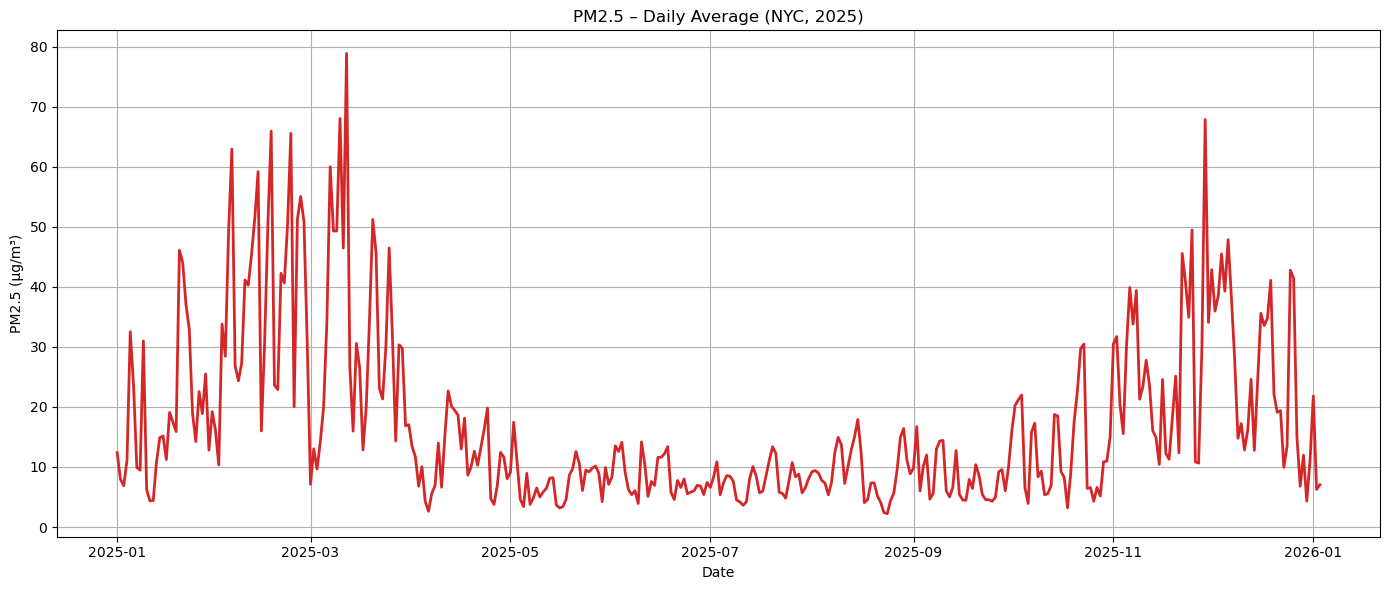

In [12]:
plt.figure(figsize=(14,6))
plt.plot(
    aq_pm25_pd["date"],
    aq_pm25_pd["pm25_avg"],
    linewidth=2,
    color="tab:red"
)

plt.title("PM2.5 – Daily Average (NYC, 2025)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
aq_no2_daily = (
    aq
    .filter(F.col("parameter_name") == "no2")
    .groupBy("date")
    .agg(F.avg("avg_value").alias("no2_avg"))
    .orderBy("date")
)

aq_no2_pd = aq_no2_daily.toPandas()

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 15, Finished, Available, Finished)

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 16, Finished, Available, Finished)

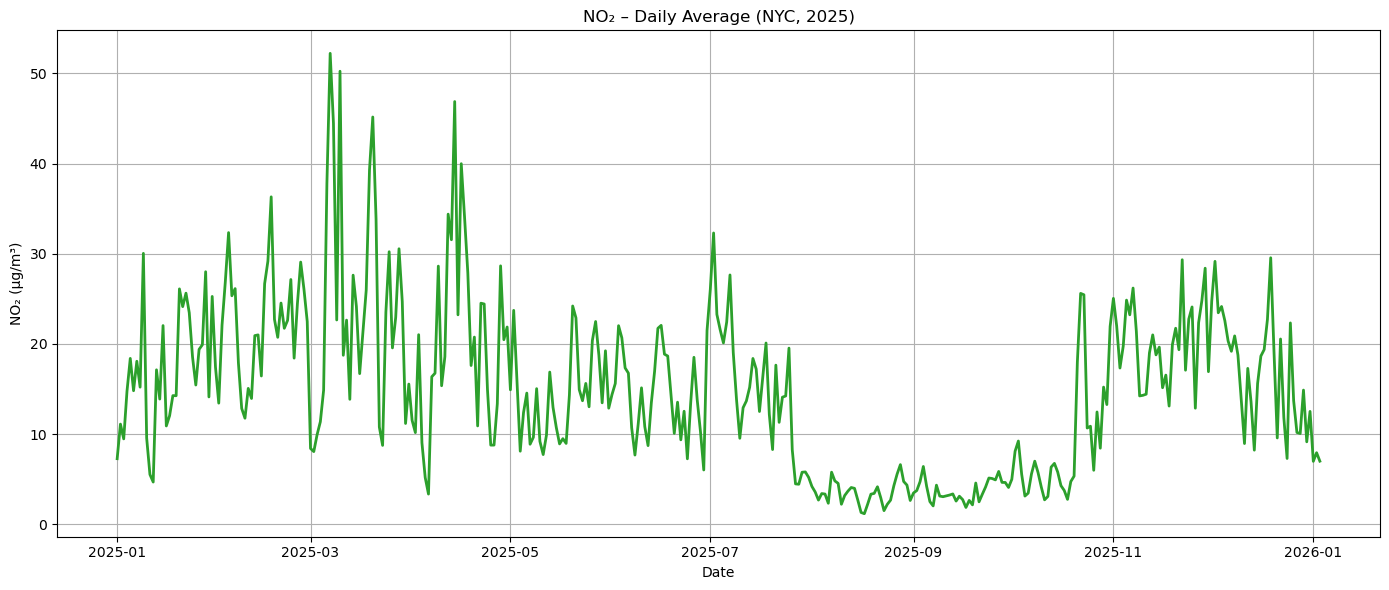

In [14]:
plt.figure(figsize=(14,6))
plt.plot(
    aq_no2_pd["date"],
    aq_no2_pd["no2_avg"],
    linewidth=2,
    color="tab:green"
)

plt.title("NO₂ – Daily Average (NYC, 2025)")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
taxi_daily = (
    fact_taxi
    .groupBy("date")
    .agg(F.sum("trips_count").alias("daily_trips"))
    .orderBy("date")
    .toPandas()
)

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 17, Finished, Available, Finished)

In [16]:
air_daily = (
    aq
    .filter(F.col("parameter_name") == "pm25")
    .groupBy("date")
    .agg(F.avg("avg_value").alias("pm25_avg"))
    .orderBy("date")
    .toPandas()
)

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 18, Finished, Available, Finished)

In [17]:
merged = taxi_daily.merge(air_daily, on="date", how="inner")

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 19, Finished, Available, Finished)

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 20, Finished, Available, Finished)

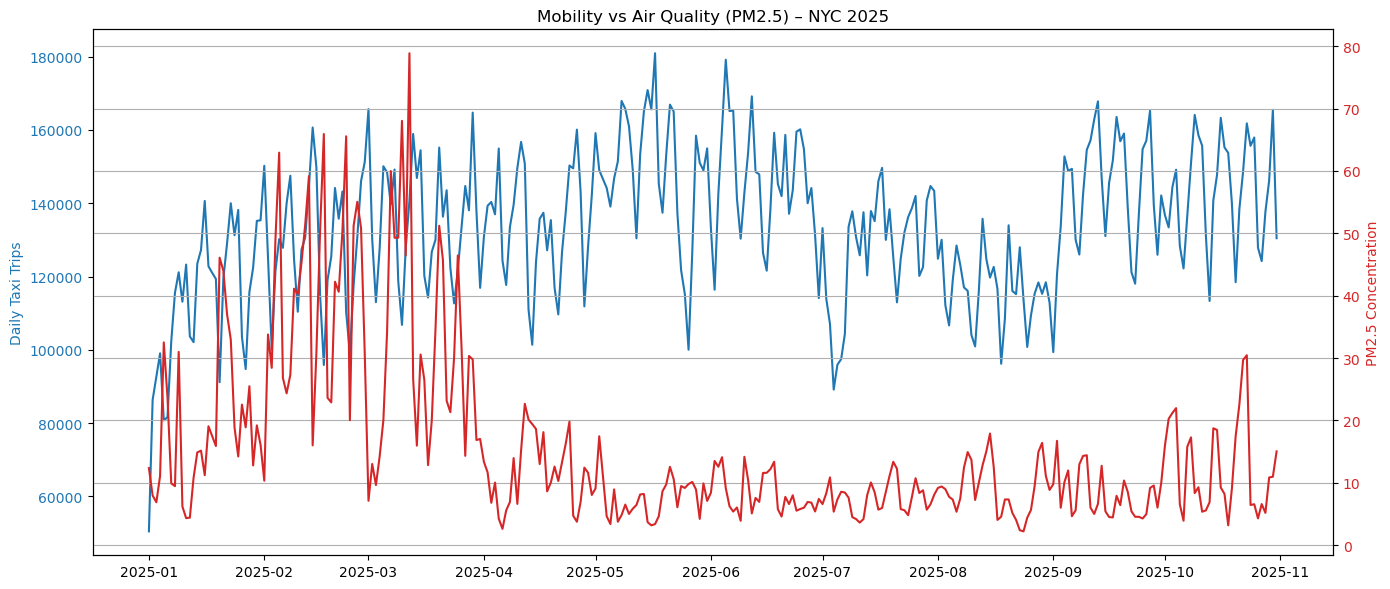

In [18]:
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(
    merged["date"],
    merged["daily_trips"],
    color="tab:blue",
    label="Taxi Trips"
)
ax1.set_ylabel("Daily Taxi Trips", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(
    merged["date"],
    merged["pm25_avg"],
    color="tab:red",
    label="PM2.5"
)
ax2.set_ylabel("PM2.5 Concentration", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("Mobility vs Air Quality (PM2.5) – NYC 2025")
fig.tight_layout()
plt.grid(True)
plt.show()

In [19]:
revenue_fx = (
    fact_taxi
    .groupBy("date")
    .agg(F.sum("total_revenue_usd").alias("revenue_usd"))
    .join(
        dim_fx,
        fact_taxi.date == dim_fx.fx_date,
        how="left"
    )
    .withColumn(
        "revenue_eur",
        F.col("revenue_usd") * F.col("usd_eur_rate")
    )
    .select(
        "date",
        "revenue_usd",
        "revenue_eur"
    )
    .orderBy("date")
)

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 21, Finished, Available, Finished)

In [20]:
revenue_pd = revenue_fx.toPandas()

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 22, Finished, Available, Finished)

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 23, Finished, Available, Finished)

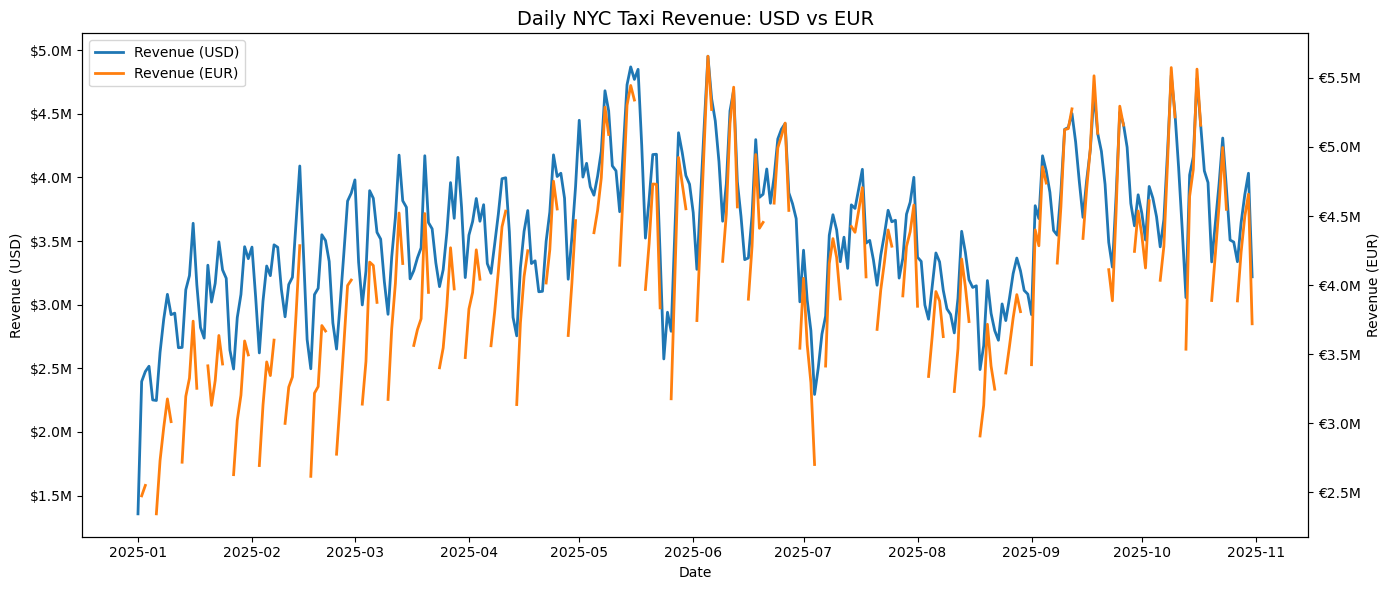

In [21]:
fig, ax1 = plt.subplots(figsize=(14, 6))

line_usd, = ax1.plot(
    revenue_pd["date"],
    revenue_pd["revenue_usd"],
    color="tab:blue",
    linewidth=2,
    label="Revenue (USD)"
)

ax1.set_ylabel("Revenue (USD)")
ax1.yaxis.set_major_formatter(
    lambda x, _: f"${x/1_000_000:.1f}M"
)

ax2 = ax1.twinx()
line_eur, = ax2.plot(
    revenue_pd["date"],
    revenue_pd["revenue_eur"],
    color="tab:orange",
    linewidth=2,
    label="Revenue (EUR)"
)

ax2.set_ylabel("Revenue (EUR)")
ax2.yaxis.set_major_formatter(
    lambda x, _: f"€{x/1_000_000:.1f}M"
)

ax1.set_title("Daily NYC Taxi Revenue: USD vs EUR", fontsize=14)
ax1.set_xlabel("Date")

lines = [line_usd, line_eur]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

fig.tight_layout()
plt.show()

In [22]:
gdp = dim_gdp.orderBy("year")
gdp_pd = gdp.toPandas()

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 24, Finished, Available, Finished)

StatementMeta(, eabb4786-b57d-4d5c-ac2b-d547c42d673f, 25, Finished, Available, Finished)

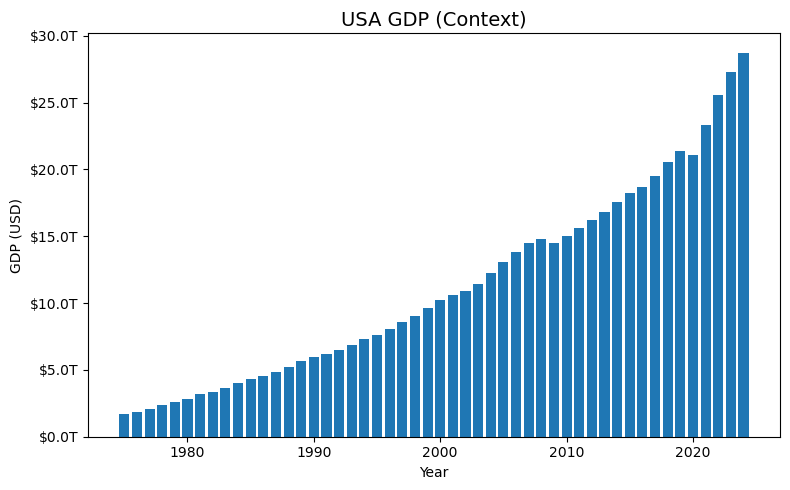

In [23]:
plt.figure(figsize=(8, 5))
plt.bar(
    gdp_pd["year"],
    gdp_pd["gdp_usd"]
)

plt.title("USA GDP (Context)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("GDP (USD)")
plt.gca().yaxis.set_major_formatter(
    lambda x, _: f"${x/1_000_000_000_000:.1f}T"
)

plt.tight_layout()
plt.show()